# Imports

In [1]:
import re
import unicodedata
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import textstat

from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm

from textblob import TextBlob
from textblob_nl import PatternAnalyzer

warnings.filterwarnings("ignore")

# set language to dutch 
textstat.set_lang("nl")

# progress bar when apply functions to dataframe
tqdm.pandas()

# better quality plots
%config InlineBackend.figure_format = "retina"

# Title font size
TITLE_SIZE = 14


# Data inladen 

Ik gebruik voor nu toch wel de dataset van 

In [2]:
#read dataset / update version 5 - feb 2025b 
df = pd.read_feather(r"C:\Users\dylan\Thesis\GIT\Datasets\NOS_NL_articles_2015_feb_2025.feather")

# Ensure 'published_time' column is in datetime format
df['published_time'] = pd.to_datetime(df['published_time'])

# Display last three rows
df.tail(4)

,channel,url,type,title,keywords,section,description,published_time,modified_time,image,content
1805,nos,https://nos.nl/l/2557705,article,"Schoof spreekt steun uit voor Oekraïne, kritie...","Schoof, Dick, nederland, trump, donald, Oekraïne",Politiek,Het Nederlandse kabinet laat weten achter Oekr...,2025-02-28 22:33:24,2025-02-28 22:33:24,https://cdn.nos.nl/image/2025/02/28/1197005/10...,"<h1>Schoof spreekt steun uit voor Oekraïne, kr..."
1806,nos,https://nos.nl/l/2557706,article,Flets Bayern doet precies genoeg en wint van S...,"Bayern München, Bundesliga, VfB Stuttgart",Voetbal,De Bundesliga-koploper speelt bepaald niet gro...,2025-02-28 22:54:12,2025-02-28 22:54:12,https://cdn.nos.nl/image/2025/02/28/1197008/10...,<h1>Flets Bayern doet precies genoeg en wint v...
1807,nos,https://nos.nl/l/2557709,article,Rodri hervat na ruim vijf maanden afwezigheid ...,"Manchester City, Rodri",Voetbal,De winnaar van de Ballon d'Or scheurde in sept...,2025-02-28 23:22:57,2025-02-28 23:22:57,https://cdn.nos.nl/image/2025/02/28/1197018/10...,<h1>Rodri hervat na ruim vijf maanden afwezigh...
1808,nos,https://nos.nl/l/2557710,article,"Ruzie is klap voor Oekraïne, 'Poetin zit te la...","Donald Trump, Nieuwsuur, Rusland, Oekraïne, Ve...",Buitenland,De ongekende aanvaring tussen Zelensky en Trum...,2025-02-28 23:34:07,2025-02-28 23:34:07,https://cdn.nos.nl/image/2025/02/28/1197020/10...,"<h1>Ruzie is klap voor Oekraïne, 'Poetin zit t..."


# Data bekijken 

### Totaal artikelen 

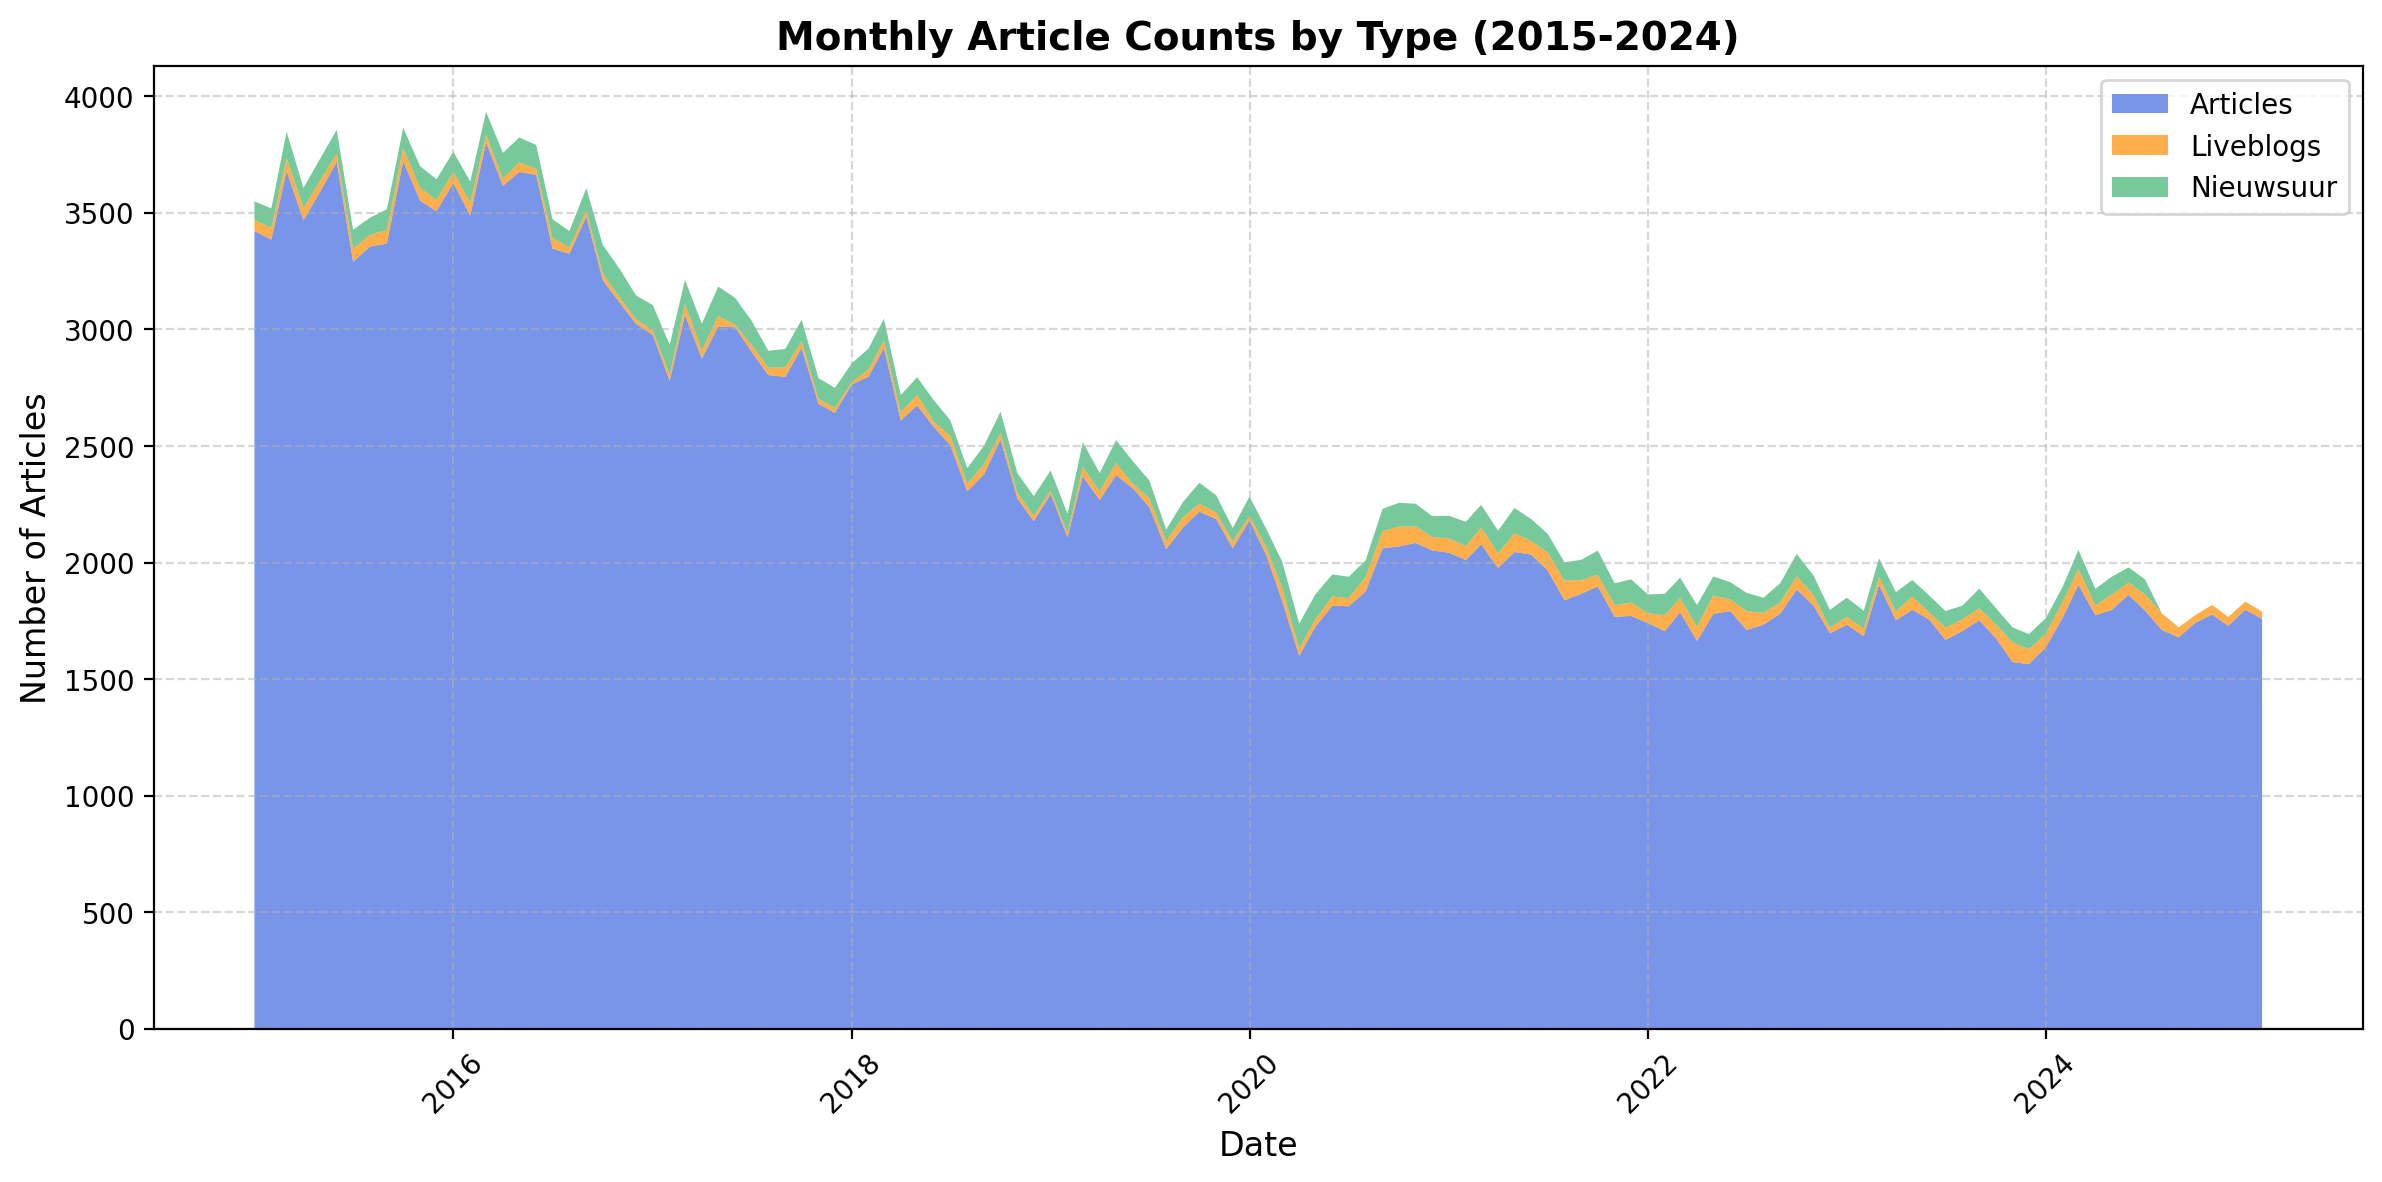

In [3]:

# Extract the year and month
df['year_month'] = df['published_time'].dt.to_period('M')

# Count the number of articles per type
article_counts = df[df['type'] == 'article'].groupby('year_month').size()
liveblog_counts = df[df['type'] == 'liveblog'].groupby('year_month').size()
nieuwsuur_counts = df[df['channel'] == 'nieuwsuur'].groupby('year_month').size()

# Convert to DataFrame for plotting
article_counts_df = article_counts.reset_index(name='article_count')
liveblog_counts_df = liveblog_counts.reset_index(name='liveblog_count')
nieuwsuur_counts_df = nieuwsuur_counts.reset_index(name='nieuwsuur_count')

# Merge the dataframes on 'year_month'
merged_df = article_counts_df.merge(liveblog_counts_df, on='year_month', how='outer').fillna(0)
merged_df = merged_df.merge(nieuwsuur_counts_df, on='year_month', how='outer').fillna(0)

# Convert periods to timestamps for plotting
merged_df['year_month'] = merged_df['year_month'].dt.to_timestamp()

# Plot the stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(merged_df['year_month'], 
              merged_df['article_count'], 
              merged_df['liveblog_count'], 
              merged_df['nieuwsuur_count'], 
              labels=['Articles', 'Liveblogs', 'Nieuwsuur'], 
              colors=['royalblue', 'darkorange', 'mediumseagreen'], 
              alpha=0.7)

# Labels and title
plt.title("Monthly Article Counts by Type (2015-2024)", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [4]:

# Extract the year from the published_time
df['year'] = df['published_time'].dt.year

# Count total occurrences for each type
total_articles = df[df['type'] == 'article'].shape[0]
total_liveblogs = df[df['type'] == 'liveblog'].shape[0]
total_nieuwsuur = df[df['channel'] == 'nieuwsuur'].shape[0]

# Calculate the number of years in the dataset
start_year = df['year'].min()
end_year = df['year'].max()
num_years = end_year - start_year + 1

# Calculate average per year for each type
avg_articles_per_year = total_articles / num_years
avg_liveblogs_per_year = total_liveblogs / num_years
avg_nieuwsuur_per_year = total_nieuwsuur / num_years

# Find the year with the maximum count for each type
articles_per_year = df[df['type'] == 'article'].groupby('year').size()
liveblogs_per_year = df[df['type'] == 'liveblog'].groupby('year').size()
nieuwsuur_per_year = df[df['channel'] == 'nieuwsuur'].groupby('year').size()

max_articles_year = articles_per_year.idxmax()
max_liveblogs_year = liveblogs_per_year.idxmax()
max_nieuwsuur_year = nieuwsuur_per_year.idxmax()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Type': ['Articles', 'Liveblogs', 'Nieuwsuur'],
    'Total Count': [total_articles, total_liveblogs, total_nieuwsuur],
    'Average per Year': [avg_articles_per_year, avg_liveblogs_per_year, avg_nieuwsuur_per_year],
    'Max Year': [max_articles_year, max_liveblogs_year, max_nieuwsuur_year]
})

# Display the table
summary_df


,Type,Total Count,Average per Year,Max Year
0,Articles,287852,26168.363636,2015
1,Liveblogs,5474,497.636364,2021
2,Nieuwsuur,10049,913.545455,2017


In [5]:
# Sentiment op alles
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline
model_name = "DTAI-KULeuven/robbert-v2-dutch-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Drop rows with missing descriptions
#df_filtered = df_filtered.dropna(subset=['description']).copy()  # Avoid modifying original DataFrame

# Apply sentiment analysis in smaller batches (for efficiency)
def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]  # Get first result
    return pd.Series([result['label'], result['score']])

# Apply sentiment analysis efficiently
df[['sentiment', 'sentiment_score']] = df['description'].apply(analyze_sentiment)

# Display the first few rows with sentiment analysis results
print(df[['title', 'description', 'sentiment', 'sentiment_score']].head())


tokenizer_config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/733k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/383k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/875 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:


# Convert published_time to datetime format if not already
df['published_time'] = pd.to_datetime(df['published_time'])

# Extract year-month for grouping
df['year_month'] = df['published_time'].dt.to_period('M')

# Calculate average sentiment score per month
sentiment_trend = df.groupby('year_month')['sentiment_score'].mean()

# Plot sentiment score over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index.astype(str), sentiment_trend, marker='o', linestyle='-', label="Average Sentiment Score", color="blue")

# Improve readability
plt.xticks(sentiment_trend.index[::5].astype(str), rotation=45, fontsize=10)  # Show every 5th month for better readability
plt.title("Average Sentiment Score Over Time", fontsize=14)
plt.xlabel("Time (Year-Month)", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


# Zet de index om naar string voor export
sentiment_trend.index = sentiment_trend.index.astype(str)

# Sla op als CSV
sentiment_trend.to_csv("sentiment_score_per_month.csv", header=["avg_sentiment_score"])


KeyError: 'Column not found: sentiment_score'

### Filteren op EVs

In [6]:
# Define search words
search_words = ["elektrische auto", "elektrische auto's.", " EV ", "EVs ", "elektrisch rijden", "laadpaal", "batterij auto", "Tesla", "e-auto", "opladen", "elektrische-automarkt"] # electrisch voertuig

# Apply the filter across multiple columns
mask = df[['title', 'keywords', 'section', 'description', 'content']].apply(
    lambda x: x.str.contains('|'.join(search_words), case=False, na=False)
).any(axis=1)

df_filtered = df[mask]


KeyboardInterrupt: 

In [12]:
# Extract year
df_filtered['year'] = df_filtered['published_time'].dt.year

# Count occurrences of each type per year
type_counts = df_filtered.groupby(['year', 'type']).size().unstack(fill_value=0)

# Count occurrences of 'nieuwsuur' as a channel separately
nieuwsuur_counts = df_filtered[df_filtered['channel'] == 'nieuwsuur'].groupby('year').size()

# Ensure 'nieuwsuur' column exists in type_counts DataFrame
type_counts['nieuwsuur'] = nieuwsuur_counts

# Fill missing values with zero if necessary
type_counts = type_counts.fillna(0)

# Calculate total articles per year (sum of all three categories)
type_counts['total'] = type_counts[['article', 'liveblog', 'nieuwsuur']].sum(axis=1)

# Calculate the average number of articles per year
average_articles_per_year = type_counts['total'].mean()


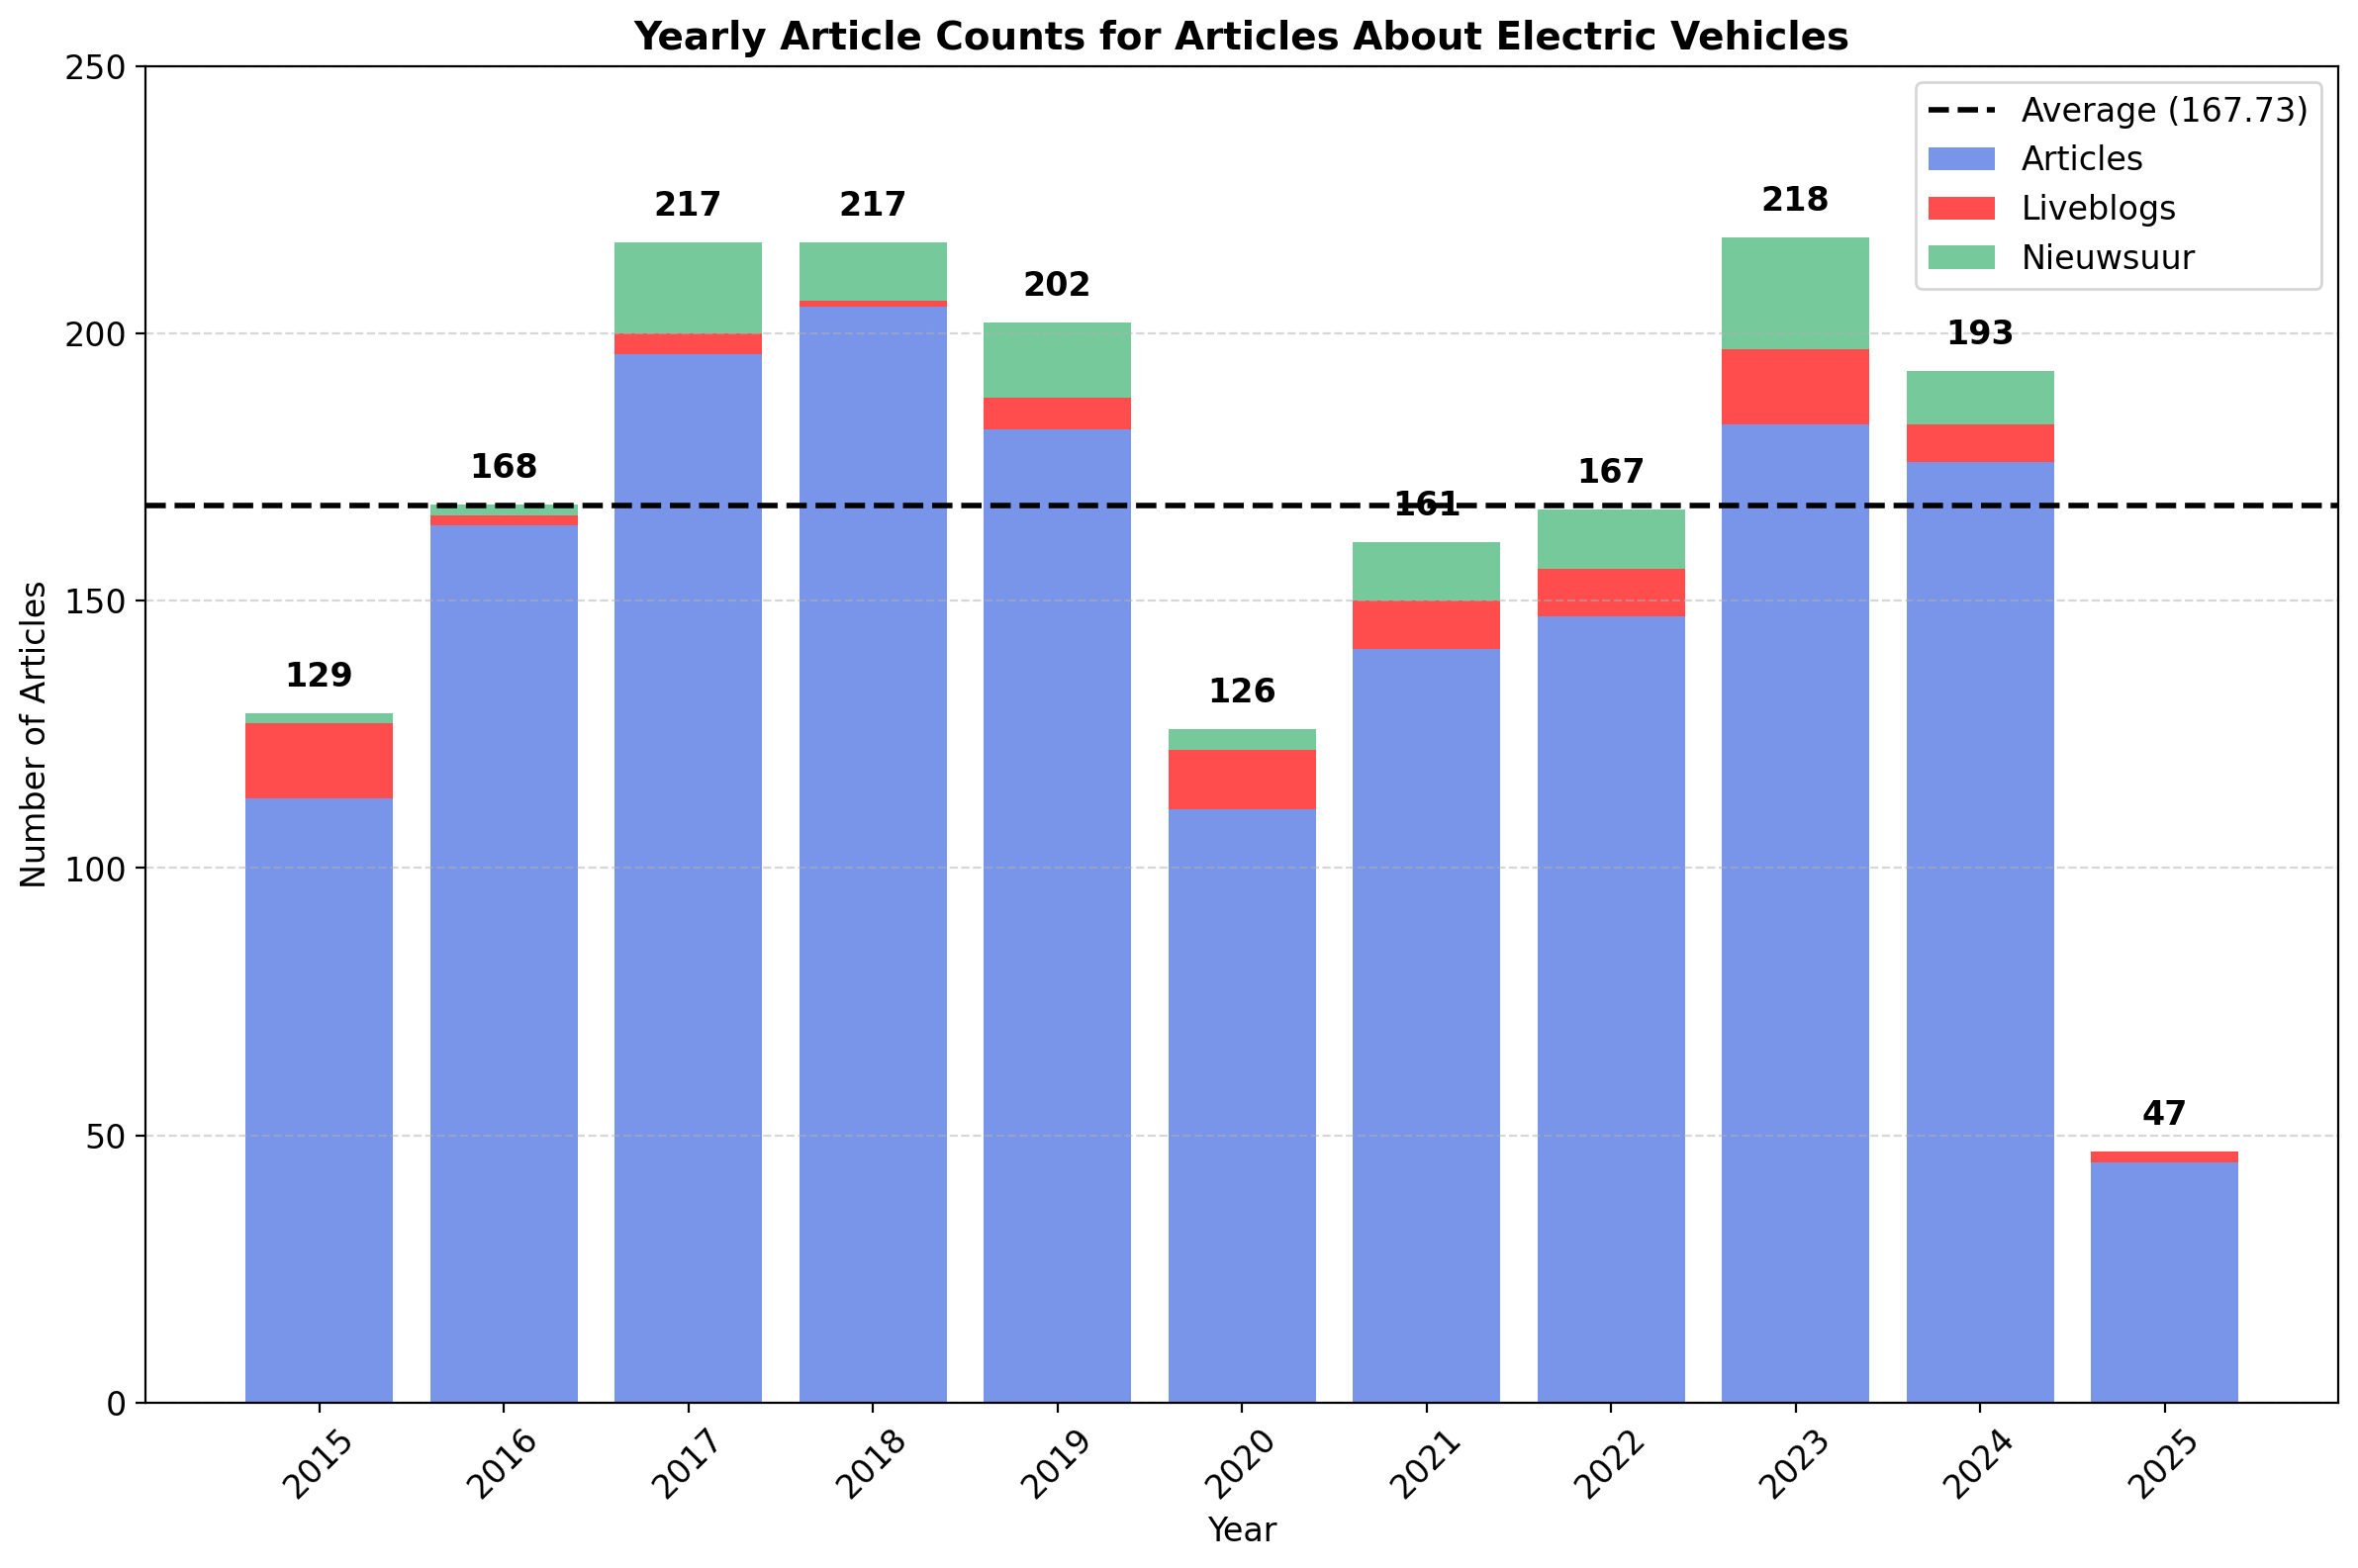

Total number of articles about electric vehicles: 1845.0


In [13]:
import matplotlib.pyplot as plt

# Plot stacked bar chart with increased y-axis limit
plt.figure(figsize=(12, 8))
bars_article = plt.bar(type_counts.index, type_counts['article'], color='royalblue', label="Articles", alpha=0.7)
bars_liveblog = plt.bar(type_counts.index, type_counts['liveblog'], bottom=type_counts['article'], color='red', label="Liveblogs", alpha=0.7)
bars_nieuwsuur = plt.bar(type_counts.index, type_counts['nieuwsuur'], bottom=type_counts['article'] + type_counts['liveblog'], color='mediumseagreen', label="Nieuwsuur", alpha=0.7)

# Add text labels for total count on top of each bar
for i, total in enumerate(type_counts['total']):
    plt.text(type_counts.index[i], total + 5, int(total), ha='center', fontsize=12, fontweight='bold')

# Add average line
plt.axhline(y=average_articles_per_year, color='black', linestyle='dashed', linewidth=2, label=f'Average ({average_articles_per_year:.2f})')

# Labels and title
plt.title("Yearly Article Counts for Articles About Electric Vehicles", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(type_counts.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.ylim(0, 250)  # Set y-axis limit to 250
plt.tight_layout()

# Show the plot
plt.show()
total_ev_articles = type_counts['total'].sum()

# Print the total count
print(f"Total number of articles about electric vehicles: {total_ev_articles}")

#### Aantal artikelen over EVs inlezen 

In [14]:
#!pip install thefuzz
from thefuzz import process

# Improved function to find matching search words in an article description using fuzzy matching
def find_fuzzy_matching_words(text):
    if pd.isna(text):  # Handle missing values
        return ""
    
    matches = []
    text_lower = text.lower()

    for word in search_words:
        # Use fuzzy matching to allow slight variations in spelling or phrasing
        score = process.extractOne(word.lower(), [text_lower])
        
        if score and score[1] > 80:  # Threshold of 80 for strong matches
            matches.append(word)
    
    return ", ".join(matches)

# Apply the fuzzy matching function to the 'description' column
df_filtered['matching_words'] = df_filtered['description'].apply(find_fuzzy_matching_words)

# Select 100 random articles and include the matching words
sample_articles_with_matches = df_filtered.sample(n=100, random_state=42)[
    ['matching_words', 'url', 'title', 'description', 'published_time']
]

# Display the table
sample_articles_with_matches


,matching_words,url,title,description,published_time
118346,,https://nos.nl/artikel/2205251-een-onbemande-w...,"Een onbemande watertaxi: het kan al wel, maar ...",Smart shipping heeft de toekomst. De techniek ...,2017-11-30 07:41:22
268972,,https://nos.nl/artikel/2501813-nobelprijswinna...,Nobelprijswinnaar Mukwege doet gooi naar presi...,Congolezen kiezen woensdag een nieuwe presiden...,2023-12-16 19:00:02
190495,"elektrische auto, elektrische auto's., batteri...",https://nos.nl/artikel/2339289-pot-voor-subsid...,Pot voor subsidie op nieuwe elektrische auto r...,Particulieren kunnen sinds gisteren subsidie a...,2020-07-02 13:21:41
202394,"elektrische auto's., elektrische-automarkt",https://nos.nl/collectie/13852/artikel/2362045...,BBC: brexit-deal gaat verder dan EU-handelsver...,De BBC heeft een exemplaar van het akkoord ing...,2020-12-26 03:37:37
152984,"elektrische auto, elektrische auto's., batteri...",https://nos.nl/artikel/2267599-volkswagen-en-f...,Volkswagen en Ford gaan samen busjes en pick-u...,Over samenwerking bij de ontwikkeling van elek...,2019-01-15 15:58:54
...,...,...,...,...,...
284108,"elektrische auto, elektrische auto's., elektri...",https://nos.nl/l/2534701,Canada komt met importheffing op Chinese elekt...,In 2023 kwamen er bijna vijf keer zoveel elekt...,2024-08-26 22:40:13
107367,,https://nos.nl/artikel/2186337-scooterrijder-k...,Scooterrijder komt om bij achtervolging met de...,De man was op de vlucht geslagen voor agenten ...,2017-08-03 22:19:38
267361,,https://nos.nl/artikel/2498253-bestuur-openai-...,Bestuur OpenAI ontslaat directeur Sam Altman d...,Onder Altmans leiding kwam het bedrijf met Cha...,2023-11-18 00:52:18
108941,,https://nos.nl/artikel/2189119-slagter-verlaat...,Slagter verlaat Cannondale voor Dimension Data,Tom-Jelte Slagter rijdt komend seizoen voor Di...,2017-08-21 16:34:21


In [ ]:
# Define the output path in Kingston (D:)
output_csv_path = r'D:\all_articles_with_matches.csv'

# Save the entire dataset with matching words to a CSV file
df_filtered.to_csv(output_csv_path, index=False)


In [ ]:
# Function to find matching search words in an article description
def find_matching_words(text):
    if pd.isna(text):  # Handle missing values
        return ""
    return ", ".join([word for word in search_words if word.lower() in text.lower()])

# Apply the function to add a new column with matching words
df_filtered['matching_words'] = df_filtered['description'].apply(find_matching_words)

# Select 100 random articles and include the matching words
sample_articles_with_matches = df_filtered.sample(n=100, random_state=42)[
    ['matching_words', 'url',  'title', 'description', 'published_time']
]

# Display the table
sample_articles_with_matches


,matching_words,url,title,description,published_time
118346,,https://nos.nl/artikel/2205251-een-onbemande-w...,"Een onbemande watertaxi: het kan al wel, maar ...",Smart shipping heeft de toekomst. De techniek ...,2017-11-30 07:41:22
268972,,https://nos.nl/artikel/2501813-nobelprijswinna...,Nobelprijswinnaar Mukwege doet gooi naar presi...,Congolezen kiezen woensdag een nieuwe presiden...,2023-12-16 19:00:02
190495,elektrische auto,https://nos.nl/artikel/2339289-pot-voor-subsid...,Pot voor subsidie op nieuwe elektrische auto r...,Particulieren kunnen sinds gisteren subsidie a...,2020-07-02 13:21:41
202394,"elektrische auto, elektrische auto's.",https://nos.nl/collectie/13852/artikel/2362045...,BBC: brexit-deal gaat verder dan EU-handelsver...,De BBC heeft een exemplaar van het akkoord ing...,2020-12-26 03:37:37
152984,,https://nos.nl/artikel/2267599-volkswagen-en-f...,Volkswagen en Ford gaan samen busjes en pick-u...,Over samenwerking bij de ontwikkeling van elek...,2019-01-15 15:58:54
...,...,...,...,...,...
284108,elektrische auto,https://nos.nl/l/2534701,Canada komt met importheffing op Chinese elekt...,In 2023 kwamen er bijna vijf keer zoveel elekt...,2024-08-26 22:40:13
107367,,https://nos.nl/artikel/2186337-scooterrijder-k...,Scooterrijder komt om bij achtervolging met de...,De man was op de vlucht geslagen voor agenten ...,2017-08-03 22:19:38
267361,,https://nos.nl/artikel/2498253-bestuur-openai-...,Bestuur OpenAI ontslaat directeur Sam Altman d...,Onder Altmans leiding kwam het bedrijf met Cha...,2023-11-18 00:52:18
108941,,https://nos.nl/artikel/2189119-slagter-verlaat...,Slagter verlaat Cannondale voor Dimension Data,Tom-Jelte Slagter rijdt komend seizoen voor Di...,2017-08-21 16:34:21


In [ ]:
# Select 100 random articles from the filtered dataset
sample_articles = df_filtered.sample(n=100, random_state=42)[['channel', 'url', 'type', 'title', 'keywords', 'section', 'description', 'published_time']]

# Display the table
print(sample_articles)


       channel                                                url     type  \
118346     nos  https://nos.nl/artikel/2205251-een-onbemande-w...  article   
268972     nos  https://nos.nl/artikel/2501813-nobelprijswinna...  article   
190495     nos  https://nos.nl/artikel/2339289-pot-voor-subsid...  article   
202394     nos  https://nos.nl/collectie/13852/artikel/2362045...  article   
152984     nos  https://nos.nl/artikel/2267599-volkswagen-en-f...  article   
...        ...                                                ...      ...   
284108     nos                           https://nos.nl/l/2534701  article   
107367     nos  https://nos.nl/artikel/2186337-scooterrijder-k...  article   
267361     nos  https://nos.nl/artikel/2498253-bestuur-openai-...  article   
108941     nos  https://nos.nl/artikel/2189119-slagter-verlaat...  article   
100940     nos  https://nos.nl/artikel/2175719-na-gemiste-el-f...  article   

                                                    title  \
11

# Sentiment Analyse
https://huggingface.co/pdelobelle/robbert-v2-dutch-base


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline
model_name = "DTAI-KULeuven/robbert-v2-dutch-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Drop rows with missing descriptions
#df_filtered = df_filtered.dropna(subset=['description']).copy()  # Avoid modifying original DataFrame

# Apply sentiment analysis in smaller batches (for efficiency)
def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]  # Get first result
    return pd.Series([result['label'], result['score']])

# Apply sentiment analysis efficiently
df_filtered[['sentiment', 'sentiment_score']] = df_filtered['description'].apply(analyze_sentiment)

# Display the first few rows with sentiment analysis results
print(df_filtered[['title', 'description', 'sentiment', 'sentiment_score']].head())


                                                  title  \
1823   Verkoop nieuwe auto's stevent af op laagterecord   
1890                                    De stroom 02/01   
2102     Proces 'Boston-marathon' start met kiezen jury   
2541  Hoe redt 'meesteroplichter' Francisco zich hie...   
2918  Wetenschappers waarschuwen voor kunstmatige in...   

                                            description sentiment  \
1823  Nederlanders kochten in 2014 opnieuw minder au...  Positive   
1890                             De stroom van NOS op 3  Positive   
2102  Een van de twee daders die levend werd gepakt,...  Positive   
2541  Vandaag staat een 20-jarige Spaanse student vo...  Negative   
2918         Een terechte waarschuwing, of overdreven?   Negative   

      sentiment_score  
1823         0.998817  
1890         0.993424  
2102         0.550519  
2541         0.889621  
2918         0.999275  


In [ ]:
import pandas as pd

# Define the output path (change if needed)
output_csv_path = r'D:\sentiment_analysis_results.csv'  # Saves to Kingston (D:)

# Select relevant columns and save to CSV
df_filtered[['title', 'description', 'sentiment', 'sentiment_score']].to_csv(output_csv_path, index=False)

print(f"Sentiment analysis results saved to: {output_csv_path}")


Sentiment analysis results saved to: D:\sentiment_analysis_results.csv


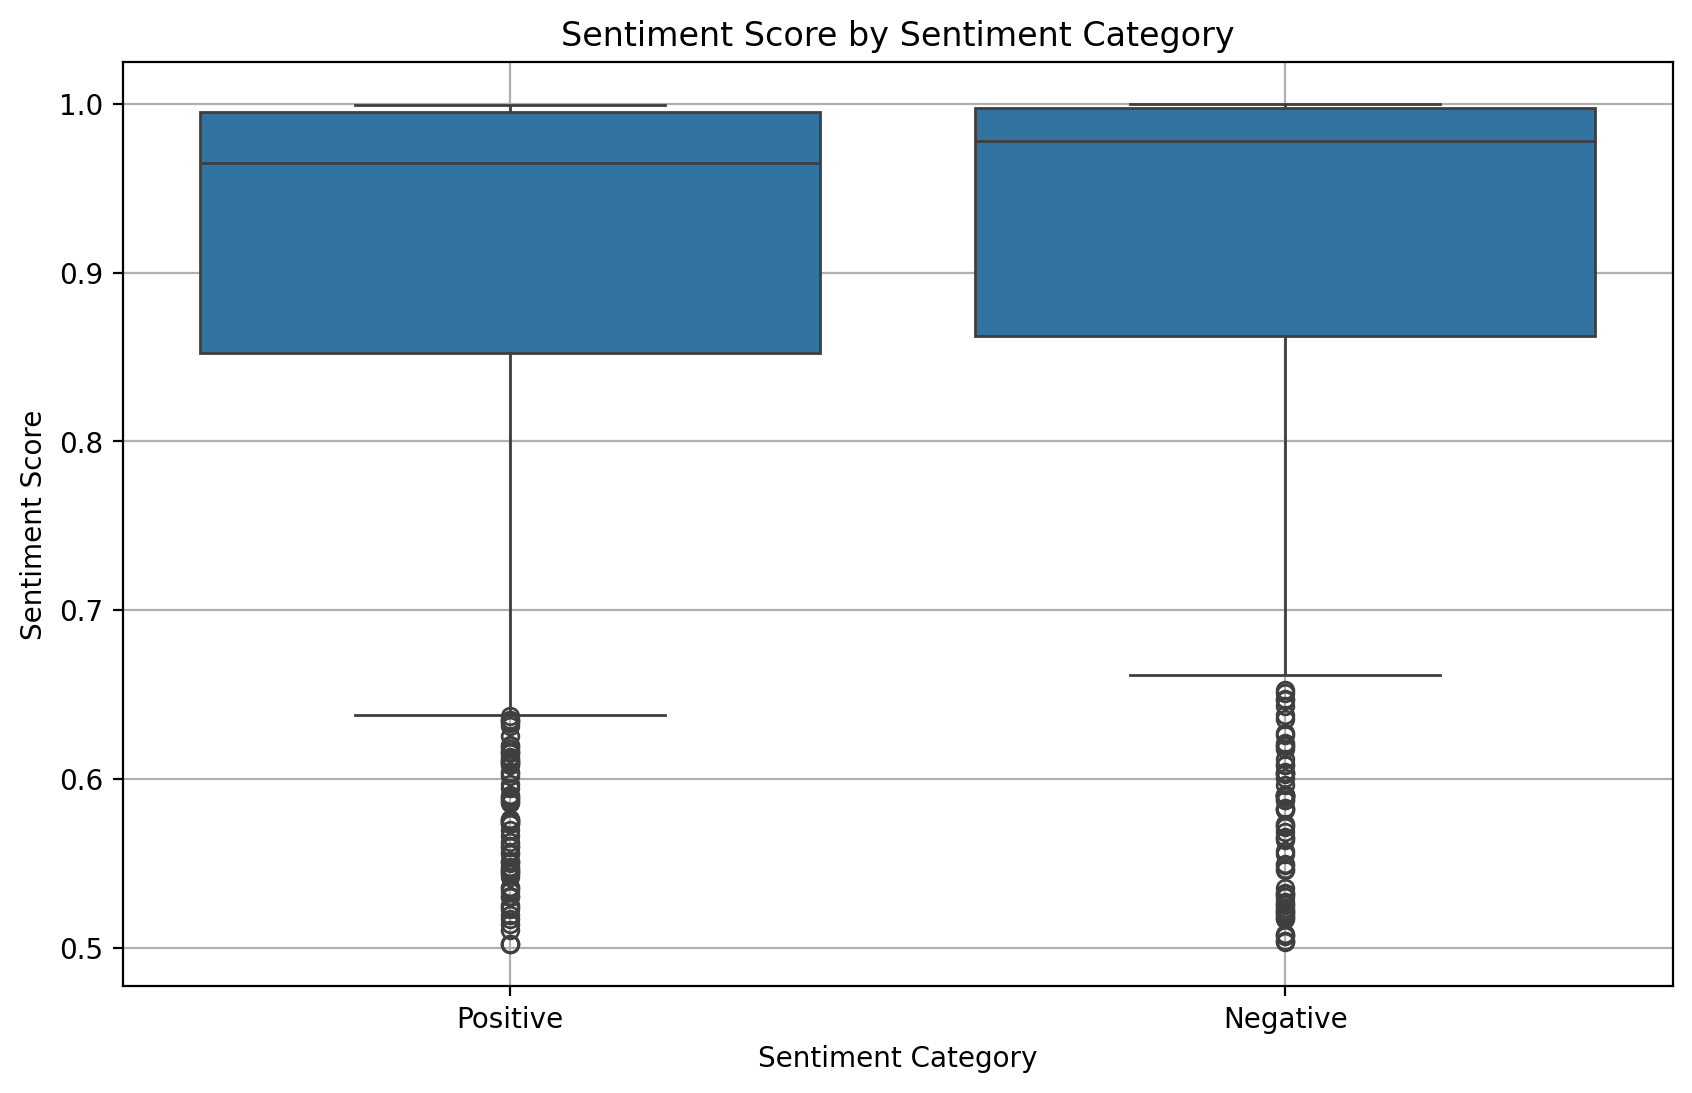

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x=df_filtered['sentiment'], y=df_filtered['sentiment_score'])

plt.title("Sentiment Score by Sentiment Category")
plt.xlabel("Sentiment Category")
plt.ylabel("Sentiment Score")
plt.grid(True)

plt.show()


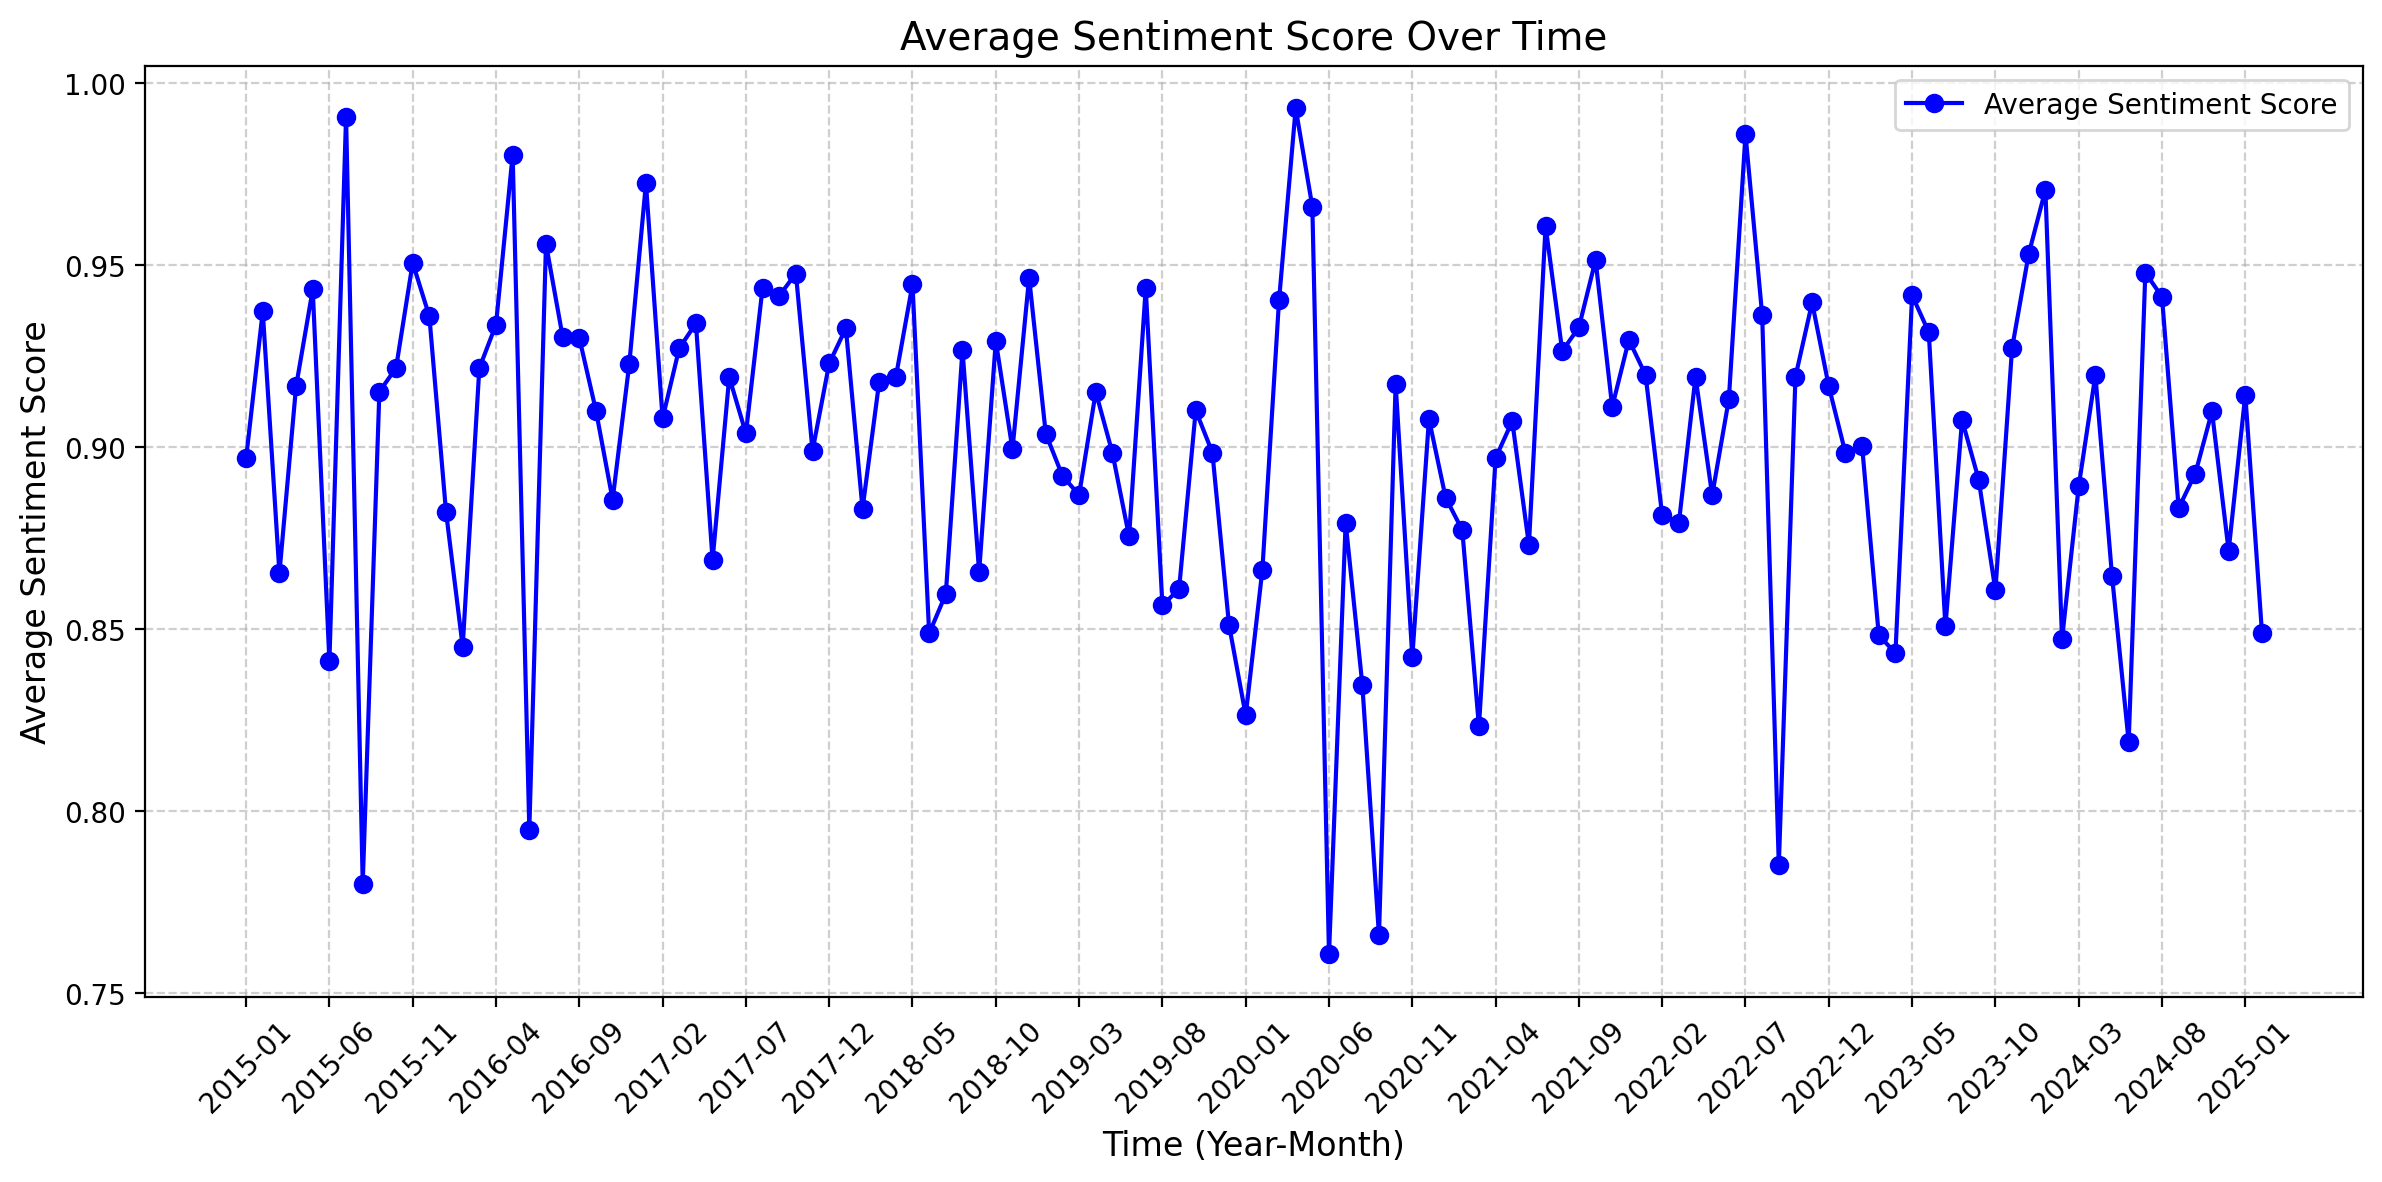

In [ ]:


# Convert published_time to datetime format if not already
df_filtered['published_time'] = pd.to_datetime(df_filtered['published_time'])

# Extract year-month for grouping
df_filtered['year_month'] = df_filtered['published_time'].dt.to_period('M')

# Calculate average sentiment score per month
sentiment_trend = df_filtered.groupby('year_month')['sentiment_score'].mean()

# Plot sentiment score over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index.astype(str), sentiment_trend, marker='o', linestyle='-', label="Average Sentiment Score", color="blue")

# Improve readability
plt.xticks(sentiment_trend.index[::5].astype(str), rotation=45, fontsize=10)  # Show every 5th month for better readability
plt.title("Average Sentiment Score Over Time", fontsize=14)
plt.xlabel("Time (Year-Month)", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()




<Figure size 1200x600 with 0 Axes>

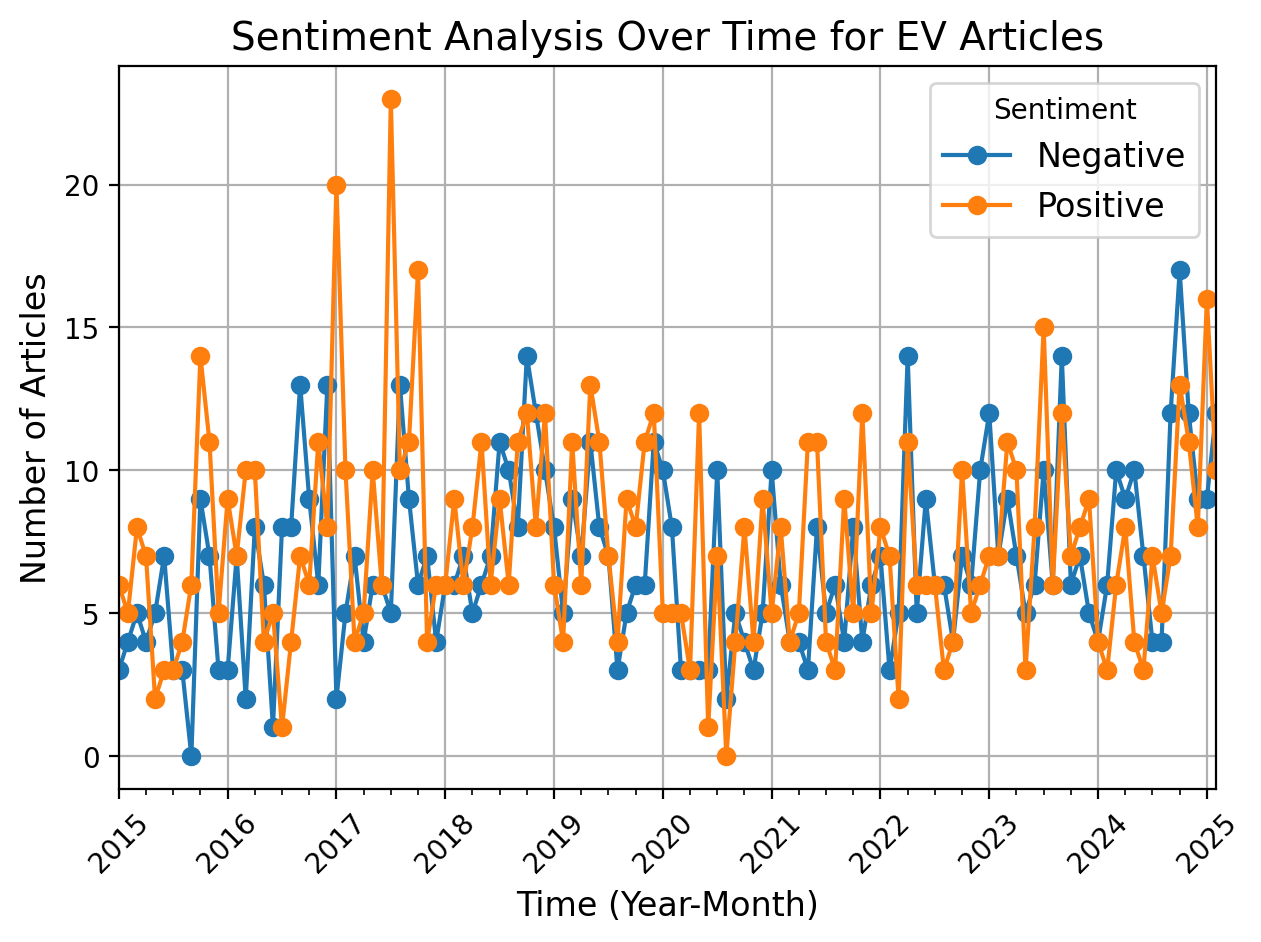

In [ ]:
df_filtered['published_time'] = pd.to_datetime(df_filtered['published_time'])

df_filtered['year_month'] = df_filtered['published_time'].dt.to_period('M')
sentiment_counts = df_filtered.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)

sentiment_counts = df_filtered.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)




plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='line', marker='o')

plt.title('Sentiment Analysis Over Time for EV Articles', fontsize=14)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Deel 2 

### Stap 1: Uitbreiden van zoekwoorden via RobBERT (semantisch)

In [15]:
! pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer, util

# Laad RobBERT via sentence-transformers
model = SentenceTransformer("pdelobelle/robbert-v2-dutch-base")

# Originele zoekwoorden
search_words = ["elektrische auto", "elektrisch rijden", "laadpaal", "Tesla", "batterij auto"]

# Woorden waartegen je wil vergelijken (je kunt hier een vocab of frequentiewoordenlijst gebruiken)
kandidaten = ["accu", "hybride", "waterstof", "laadsessie", "EV", "e-auto", "elektrische wagen", "diesel", "brandstof", "opladen", "stekkerauto", "mobility", "duurzaam rijden", "laadstation", "volledig elektrisch"]

# Embed alles
query_embeddings = model.encode(search_words, convert_to_tensor=True)
kandidaat_embeddings = model.encode(kandidaten, convert_to_tensor=True)

# Bereken semantische overeenkomsten
similarities = util.pytorch_cos_sim(query_embeddings, kandidaat_embeddings)

# Stel drempel in: alleen toevoegen als semantische score hoog genoeg is
threshold = 0.6
extra_keywords = set()

for i, word in enumerate(search_words):
    for j, score in enumerate(similarities[i]):
        if score > threshold:
            extra_keywords.add(kandidaten[j])

# Combineer originele en uitgebreide zoekwoorden
all_keywords = list(set(search_words) | extra_keywords)

print("Uitgebreide zoekwoordenlijst:")
print(all_keywords)


No sentence-transformers model found with name pdelobelle/robbert-v2-dutch-base. Creating a new one with mean pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Uitgebreide zoekwoordenlijst:
['hybride', 'batterij auto', 'EV', 'laadstation', 'accu', 'diesel', 'opladen', 'elektrische auto', 'elektrisch rijden', 'laadsessie', 'waterstof', 'laadpaal', 'brandstof', 'e-auto', 'elektrische wagen', 'duurzaam rijden', 'Tesla', 'stekkerauto', 'mobility', 'volledig elektrisch']


###  Stap 2: Pas nieuwe zoekwoorden toe in je filter

In [16]:
# Apply the filter across multiple columns
mask = df[['title', 'keywords', 'section', 'description', 'content']].apply(
    lambda x: x.str.contains('|'.join(all_keywords), case=False, na=False)
).any(axis=1)

df_filtered = df[mask]


In [17]:
df_filtered[['sentiment', 'sentiment_score']] = df_filtered['description'].apply(analyze_sentiment)


KeyboardInterrupt: 

### 1Setup: import en model

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Laad RobBERT model
model = SentenceTransformer("pdelobelle/robbert-v2-dutch-base")
